## Text Classification
- Objective: Develop a comprehensive text classification system that involves web scraping, Named Entity Recognition (NER), Sentiment Analysis, and Topic Modeling.

### 1. Web Scraping
- Task: Scrape news articles or blog posts from a website of your choice. Ensure you choose a site that allows scraping and has a substantial amount of text content (e.g., news portal, blog site).
- Goal: Collect at least 100 articles/posts on a specific theme or topic (e.g., technology, health, politics). The content should be varied enough to allow for interesting NER, sentiment analysis, and topic modeling results.

In [4]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

In [5]:
def bsoup(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    return soup

In [27]:
# Scrape time.com health section
url = "https://time.com/section/health/?page="

all_headlines = []
all_elements = []
titles = []
articles = []

# Loop through each page
for page in range(1, 21):   
    soup = bsoup(url+str(page))
    all_headlines.append(soup.find('body').find_all('h2'))
    all_elements.append(soup.find_all('div', class_='taxonomy-tout'))

# Title
for headlines in all_headlines:
    for x in headlines:
        titles.append(x.text.strip())

# Article
for elements in all_elements:
    for e in elements:
        a_element = e.find('a')
        if a_element and 'href' in a_element.attrs:
            url = 'https://time.com' + a_element['href']
            soup = bsoup(url)

            #print(url)
            if soup.find("div", {"id":"page-content"}) is not None:
                if soup.find("div", {"id":"article-body-main"}) is not None:
                    text = soup.find("div", {"id":"article-body-main"}).text
                else:
                    text = soup.find("div", {"id":"article-body"}).text
            else:
                text = ""
            
            articles.append(text)

In [28]:
df = pd.DataFrame({'title':titles, 'article':articles})
df

,title,article
0,How COVID-19 Vaccines and Infections Are Tweak...,Your immune system may be getting smarter ever...
1,Cameroon Starts World-First Malaria Vaccine Pr...,Cameroon will be the first country to routinel...
2,Charcuterie Is Linked to Salmonella,Federal health officials are expanding a warni...
3,Multivitamins May Slow Brain Aging,"Aging is inevitable, but that doesn’t stop us ..."
4,How Pigs Could Help People Who Need Liver Tran...,"Organ transplants save lives, but healthy spec..."
...,...,...
395,Democratic States Are Stockpiling Abortion Pills,The future of access to the abortion pill in t...
396,Why the Adderall Shortage Has Lasted So Long,"In October 2022, the U.S. Food and Drug Admini..."
397,How Doctors Inadvertently Fat-Shame Kids,"When Beth Nathan was 10 years old, her pediatr..."
398,The Latest Promising Long COVID Treatment? Psy...,After more than a year of being short of breat...


In [29]:
df['article'][0]

"Your immune system may be getting smarter every time you encounter COVID-19, a new study suggests. After getting vaccinated and infected, the immune system generates broader defenses against the virus, including against new variants.In a paper published Jan. 19 in Science Immunology, researchers in South Korea compared immune cells in the lab from people with a variety of vaccine and infection histories throughout the different Omicron waves, which began in late 2021 with BA.1. People who had been vaccinated with the original Pfizer-BioNTech series and then got infected with any Omicron variant showed good levels of memory immune cells—called T cells—that defended not only against the variants causing the infection, but also related ones in the Omicron family that came later. For example, people who were vaccinated with three doses of the original COVID-19 shot and then got infected with the BA.2 variant generated T cells that could target not just BA.2 but also BA.4/5 and XBB viruses

### 2. Named Entity Recognition
- Task: Utilize an NLP library like spaCy or NLTK to perform NER on the collected text. Identify and categorize all named entities (e.g., persons, organizations, locations).
- Goal: Understand the distribution of named entities in your dataset and how they relate to the content's topic or sentiment.

In [30]:
import spacy
from collections import Counter
import matplotlib.pyplot as plt

/opt/homebrew/lib/python3.11/site-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
/opt/homebrew/lib/python3.11/site-packages/thinc/compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]


In [31]:
nlp = spacy.load('en_core_web_sm')
nlp_articles = []
for article in articles:
    nlp_articles.append(nlp(article))

In [32]:
# Count # of times each entity label appears
label_counter = Counter(ent.label_ for article in nlp_articles for ent in article.ents)
sorted_label_count_pairs = label_counter.most_common()

print("Total # of Entity Labels:", len(sorted_label_count_pairs))
print("Total Sum of Entity Label Counts:", sum(count for label, count in sorted_label_count_pairs))

for label, count in sorted_label_count_pairs:
    print(f"{label}: {count}")

Total # of Entity Labels: 18
Total Sum of Entity Label Counts: 25267
ORG: 6447
DATE: 4786
PERSON: 4466
CARDINAL: 3113
GPE: 2689
PERCENT: 835
NORP: 802
ORDINAL: 637
TIME: 392
MONEY: 247
LOC: 228
PRODUCT: 169
WORK_OF_ART: 147
QUANTITY: 103
FAC: 92
LAW: 62
EVENT: 41
LANGUAGE: 11


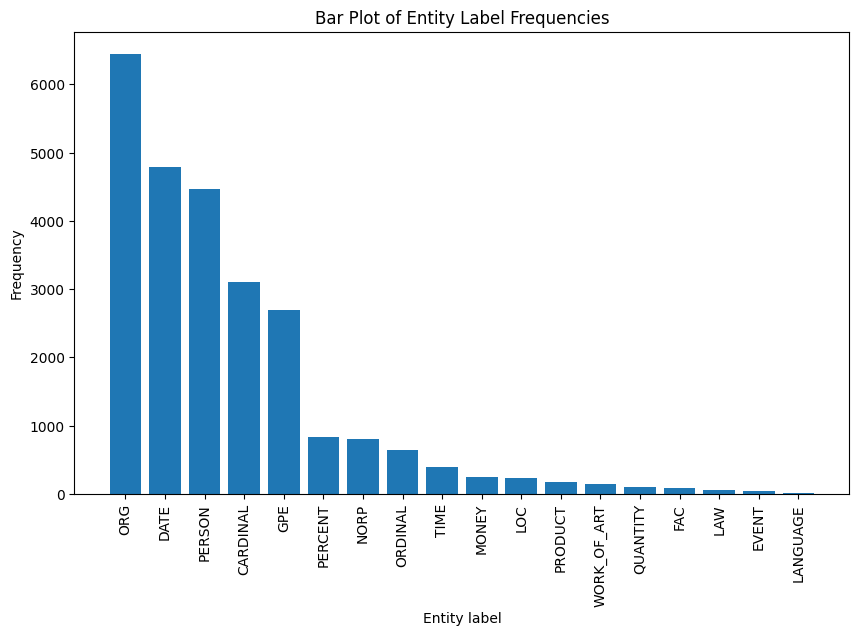

In [33]:
labels, frequencies = zip(*sorted_label_count_pairs)

plt.figure(figsize=(10, 6))
plt.bar(labels, frequencies)
plt.xticks(labels, rotation=90)
plt.xlabel('Entity label')
plt.ylabel('Frequency')
plt.title("Bar Plot of Entity Label Frequencies")
plt.show()

In [34]:
# Top 10 most frequently occurring entities (entity text and the number of occurence) 
common_org = Counter()
common_per = Counter()

for article in nlp_articles:
    org_list = set([ent.lemma_.lower() for ent in article.ents if ent.label_ == u"ORG"])
    per_list = set([ent.lemma_.lower() for ent in article.ents if ent.label_ == u"PERSON"])
    
    common_org.update(org_list)
    common_per.update(per_list)

print("Total # of Org Labels:", len(common_org.items()))
print('Most frequently occurring organizations:')
print("\n".join(["  %s: %d" % (entity, count) for entity, count in common_org.most_common(10)]))
print()
print("Total # of Person Labels:", len(common_per.items()))
print('Most frequently occurring persons:')
print("\n".join(["  %s: %d" % (entity, count) for entity, count in common_per.most_common(10)]))

Total # of Org Labels: 2357
Most frequently occurring organizations:
  covid-19: 121
  fda: 74
  cdc: 58
  the u.s. food and drug administration: 57
  the u.s. centers for disease control and prevention: 49
  time: 47
  the world health organization: 25
  rsv: 23
  omicron: 22
  the centers for disease control and prevention: 22

Total # of Person Labels: 2241
Most frequently occurring persons:
  covid-19: 56
  pfizer: 15
  moderna: 13
  paxlovid: 9
  wegovy: 9
  covid: 8
  donald trump: 7
  biden: 7
  joe biden: 7
  brown: 6


### 3. Sentiment Analysis
- Task: Perform sentiment analysis on each article or post using any standard sentiment analysis tool or library (e.g., TextBlob, VADER, custom model).
- Goal: Determine the overall sentiment distribution across your corpus. Is the sentiment predominantly positive, negative, or neutral? How does sentiment relate to the topics discovered in the next step?

In [35]:
import nltk
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/talktalki/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [36]:
sent_scores = []
sent_class = []
vader_scores = []
vader_class = []
sid = SentimentIntensityAnalyzer()

for article in articles:
    blob = TextBlob(article)
    
    # Get the sentiment polarity (-1 to 1)
    sentiment_polarity = blob.sentiment.polarity
    vader_score = sid.polarity_scores(article)

    sent_scores.append(sentiment_polarity)
    sent_class.append('Positive' if sentiment_polarity >= 0 
                      else 'Negative' if sentiment_polarity <= 0 else 'Neutral')

    vader_scores.append(vader_score['compound'])
    vader_class.append('Positive' if vader_score['compound'] >= 0.05 
                       else 'Negative' if vader_score['compound'] <= -0.05 else 'Neutral')

df['textblob_score'] = sent_scores
df['textblob_class'] = sent_class
df['vader_score'] = vader_scores
df['vader_class'] = vader_class

In [37]:
df[:50]

,title,article,textblob_score,textblob_class,vader_score,vader_class
0,How COVID-19 Vaccines and Infections Are Tweak...,Your immune system may be getting smarter ever...,0.074839,Positive,0.9767,Positive
1,Cameroon Starts World-First Malaria Vaccine Pr...,Cameroon will be the first country to routinel...,0.131687,Positive,0.9724,Positive
2,Charcuterie Is Linked to Salmonella,Federal health officials are expanding a warni...,0.001389,Positive,-0.9636,Negative
3,Multivitamins May Slow Brain Aging,"Aging is inevitable, but that doesn’t stop us ...",0.174318,Positive,0.9974,Positive
4,How Pigs Could Help People Who Need Liver Tran...,"Organ transplants save lives, but healthy spec...",0.143841,Positive,0.9678,Positive
5,Complementary Treatments for Lupus,Being diagnosed with a chronic illness can be ...,0.181655,Positive,0.9995,Positive
6,How Long Does It Take to Get COVID-19?,With COVID-19 spreading as widely as it is rig...,0.003473,Positive,-0.6976,Negative
7,Hong Kong No Longer Has World’s Longest Life E...,Hong Kong residents no longer have the world’s...,0.065679,Positive,-0.9688,Negative
8,How to Scale Back on Social Media,Emma Lembke joined Instagram when she was 12. ...,0.088674,Positive,0.9944,Positive
9,Is It Time for a Surgeon General Report on Vap...,"NEW YORK — Sixty years ago, the U.S. surgeon g...",0.091275,Positive,-0.9545,Negative


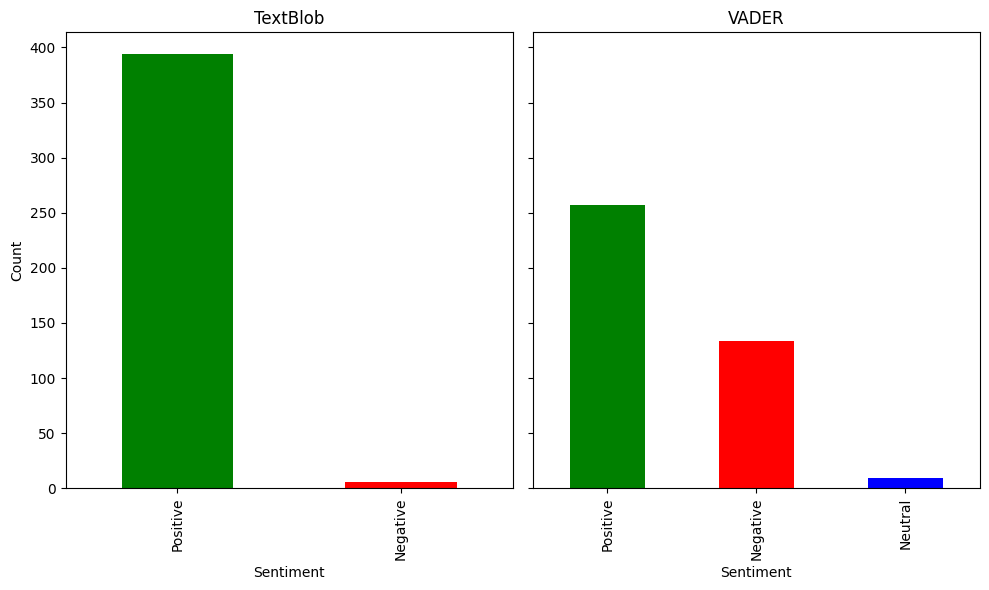

In [38]:
textblob_counts = df['textblob_class'].value_counts()
vader_counts = df['vader_class'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
bars_col1 = textblob_counts.plot(kind='bar', color=['green', 'red', 'blue'], ax=axs[0])
axs[0].set_title('TextBlob')
axs[0].set_xlabel('Sentiment')
axs[0].set_ylabel('Count')

vader_counts.plot(kind='bar', color=['green', 'red', 'blue'], ax=axs[1])
axs[1].set_title('VADER')
axs[1].set_xlabel('Sentiment')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### 4. Topic Modeling
- Task: Implement a topic modeling technique (e.g., LDA, NMF) to discover the underlying topics in your corpus. You may use libraries like Gensim or scikit-learn.
- Goal: Identify the main topics and their distribution across your dataset. How do these topics correlate with the named entities and sentiments found?

### Scikit-learn

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [40]:
vocab_size = 1000
tfidf_vectorizer = TfidfVectorizer(max_df=0.95,
                                    min_df=5,
                                    stop_words='english',
                                    max_features=vocab_size)            
X_tfidf = tfidf_vectorizer.fit_transform(articles)

num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(X_tfidf)

LatentDirichletAllocation(n_components=5, random_state=0)

In [41]:
num_top_words = 10
topic_word_distributions = np.array([row / row.sum() for row in lda.components_])
vocab = tfidf_vectorizer.get_feature_names_out()

def print_top_words(topic_word_distributions, num_top_words):
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()

    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx], ':', topic_word_distributions[topic_idx, word_idx])
        print()

print_top_words(topic_word_distributions, num_top_words)

Displaying the top 10 words per topic and their probabilities within the topic...

[Topic 0]
heat : 0.04061143809021969
air : 0.011514730145899753
temperatures : 0.008440735135177676
smoke : 0.007956135854935839
temperature : 0.00794809641546002
extreme : 0.006266426520870409
bugs : 0.006083447375873301
hot : 0.005361554778828755
cool : 0.0047782868632774075
climate : 0.0030084779944778237

[Topic 1]
lyme : 0.01321414018859252
tick : 0.009787067230054633
ticks : 0.009625656817223084
temperatures : 0.001033954449874373
bugs : 0.0010235834852354686
vaccinated : 0.0009977355373855111
bacteria : 0.0009899469735297807
antibodies : 0.0009895372998786243
died : 0.0009796283775531122
infection : 0.0009790168618596272

[Topic 2]
abortion : 0.03642546917339349
pfas : 0.01670558926682634
abortions : 0.011694401685041345
mifepristone : 0.011601544654049492
court : 0.002181265333558141
legal : 0.000975956548880302
texas : 0.0009603420810104027
restrictions : 0.0009527965107120832
clinics : 0.000947

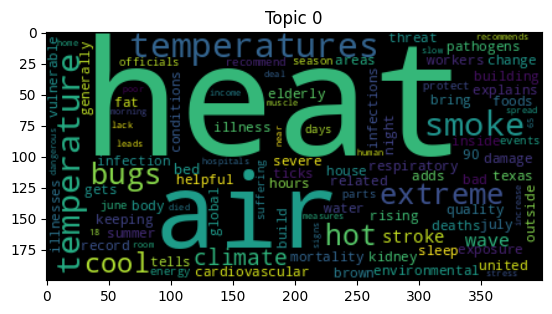

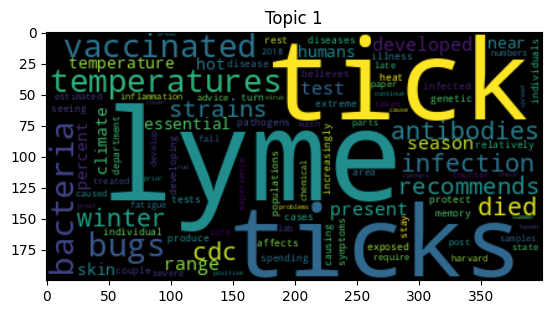

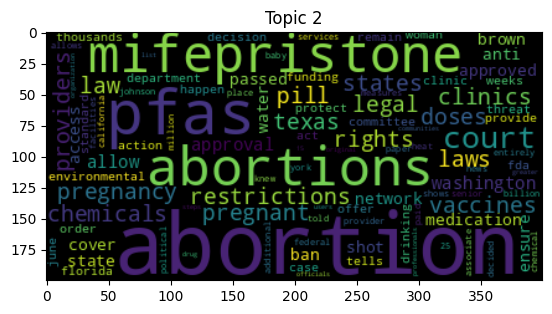

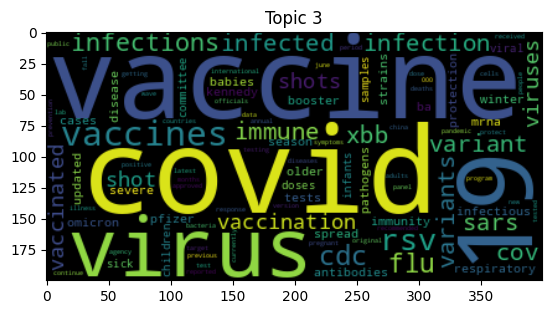

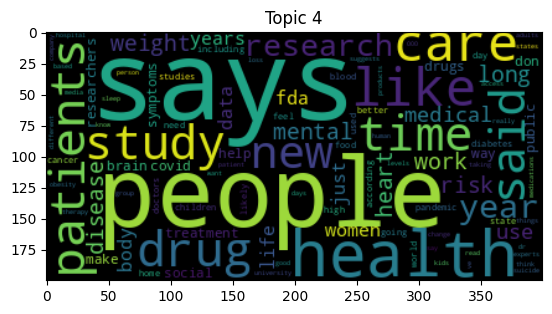

In [42]:
from wordcloud import WordCloud

num_max_word_cloud_words = 100

for topic_idx in range(num_topics):
    wc = WordCloud(max_words=num_max_word_cloud_words)
    wc.generate_from_frequencies(dict(zip(vocab, topic_word_distributions[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.title('Topic %d' % topic_idx)

### Gensim

In [43]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, TfidfModel
import pyLDAvis
import pyLDAvis.gensim_models

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [44]:
# Function for tokenization
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))            #deacc=True removes punctuations

# Functions for stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Function for bigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Lemmatize
def lemmatize_spacy(texts, pos=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for i in texts:
        doc = nlp(" ".join(i)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in pos])
    return texts_out

In [45]:
# Tokenize
tokens = list(sent_to_words(articles))

# Remove Stop Words
tokens_nostops = remove_stopwords(tokens)

# Form Bigrams
bigram = gensim.models.Phrases(tokens_nostops, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)
tokens_bigrams = make_bigrams(tokens_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
nlp = spacy.load('en_core_web_sm')
data_lemmatized = lemmatize_spacy(tokens_bigrams, pos=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(len(tokens[0]), tokens[0])
print(len(tokens_nostops[0]), tokens_nostops[0])
print(len(tokens_bigrams[0]), tokens_bigrams[0])
print(len(data_lemmatized[0]), data_lemmatized[0])

600 ['your', 'immune', 'system', 'may', 'be', 'getting', 'smarter', 'every', 'time', 'you', 'encounter', 'covid', 'new', 'study', 'suggests', 'after', 'getting', 'vaccinated', 'and', 'infected', 'the', 'immune', 'system', 'generates', 'broader', 'defenses', 'against', 'the', 'virus', 'including', 'against', 'new', 'variants', 'in', 'paper', 'published', 'jan', 'in', 'science', 'immunology', 'researchers', 'in', 'south', 'korea', 'compared', 'immune', 'cells', 'in', 'the', 'lab', 'from', 'people', 'with', 'variety', 'of', 'vaccine', 'and', 'infection', 'histories', 'throughout', 'the', 'different', 'omicron', 'waves', 'which', 'began', 'in', 'late', 'with', 'ba', 'people', 'who', 'had', 'been', 'vaccinated', 'with', 'the', 'original', 'pfizer', 'biontech', 'series', 'and', 'then', 'got', 'infected', 'with', 'any', 'omicron', 'variant', 'showed', 'good', 'levels', 'of', 'memory', 'immune', 'cells', 'called', 'cells', 'that', 'defended', 'not', 'only', 'against', 'the', 'variants', 'causi

In [46]:
dictionary = corpora.Dictionary(data_lemmatized)
dictionary.filter_extremes(no_below=5, no_above=0.95, keep_n=1000)
corpus = [dictionary.doc2bow(text) for text in data_lemmatized]
corpus_tfidf = TfidfModel(corpus)[corpus]

In [47]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=dictionary,
                                           num_topics=5, 
                                           random_state=0,
                                           chunksize=2000,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

In [48]:
# Function to get topics
def get_topics(model, num_topics):
    word_dict = {}
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict)

In [49]:
# Get Topics
get_topics(lda_model, 5)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,test,vaccine,cancer,vaccine,drug
1,virus,covid,mental,talk,vaccine
2,covid,drug,thought,feel,obesity
3,social_media,patient,cell,kid,virus
4,detect,care,drug,friend,variant
5,mask,virus,patient,child,medication
6,variant,test,brain,baby,state
7,air,woman,sleep,relationship,infection
8,human,mental,treatment,conversation,patient
9,pathogen,infection,story,drug,covid


In [50]:
# Compute Perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus_tfidf))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -7.307672594102719
Coherence Score:  0.2977173972587763
